# 2022-09-05 • Why are some connections not detected

..plus a middle section with a sim with different spike transmission delay and capacitance (~time ct), and averaging some function of the STA of all other neurons in the net, to find the time scale.

..plus: modelling the PSP's shape.

## Imports

In [19]:
#

In [20]:
using Revise

In [21]:
using MyToolbox

In [22]:
using VoltoMapSim

[ Info: Precompiling VoltoMapSim [f713100b-c48c-421a-b480-5fcb4c589a9e]


## Params

In [5]:
d = 1
p = get_params(
    duration = 10minutes,
    p_conn = 0.04,
    g_EE = 1 / d,
    g_EI = 1 / d,
    g_IE = 4 / d,
    g_II = 4 / d,
    ext_current = Normal(-0.5 * pA/√seconds, 5 * pA/√seconds),
    E_inh = -80 * mV,
    record_v = [1:40; 801:810],
);

## Run sim

In [6]:
s = cached(sim, [p.sim]);

In [7]:
s = augment_simdata(s, p);

## STA of undetected inputs (E→E)

In [8]:
perf = cached_conntest_eval(s, 1, p)
perf.detection_rates

(TPR_exc = 0.615, TPR_inh = 0.9, FPR = 0.125)

See prev notebook for classification table.

I'm gonna go through the misclassified ones one by one.

In [23]:
using PyPlot
using VoltoMapSim.Plot

The exc inputs classified as inh were plotted before: a shorter window will remedy those.

But what about the undetected ones.

In [33]:
tn = perf.tested_neurons;

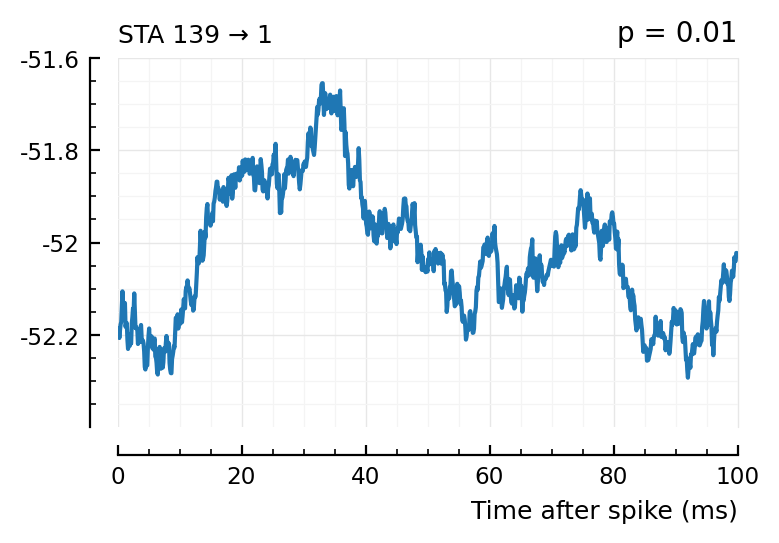

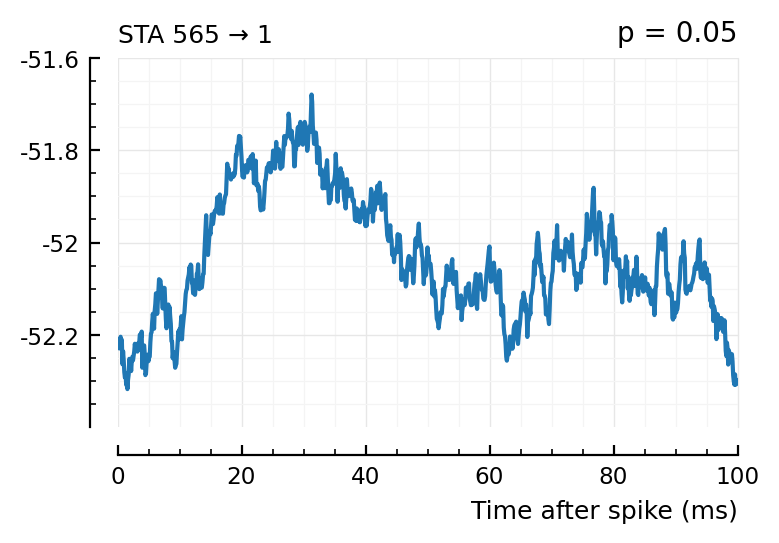

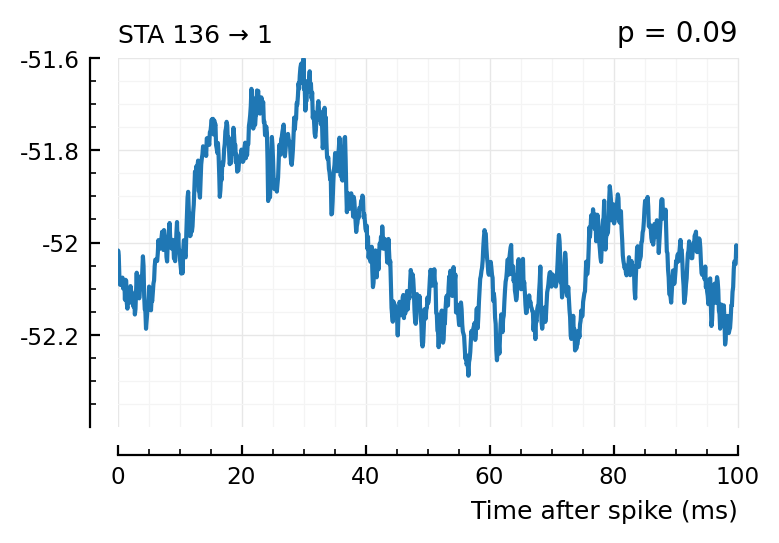

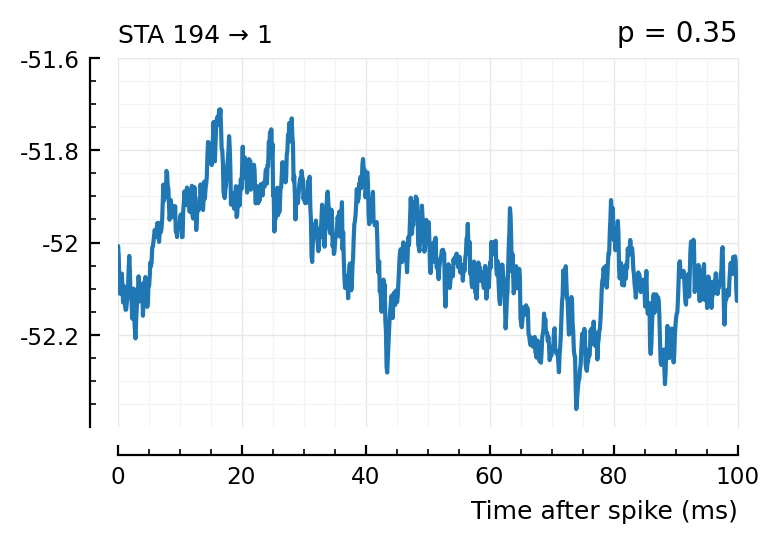

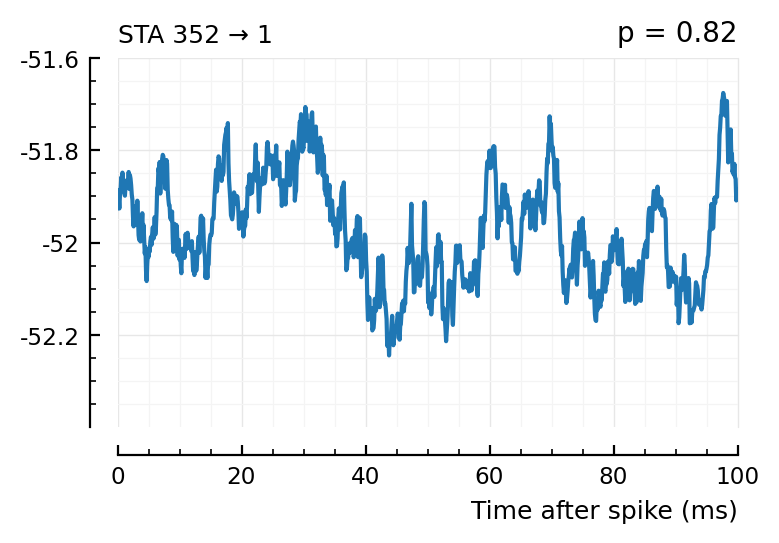

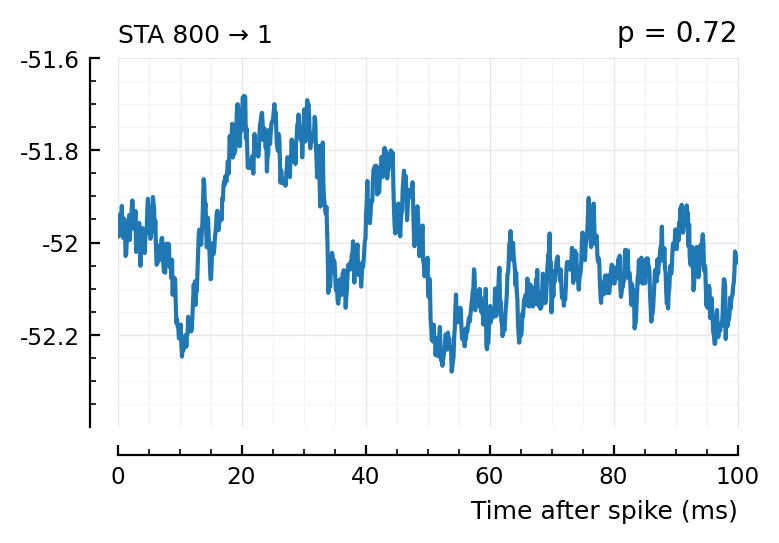

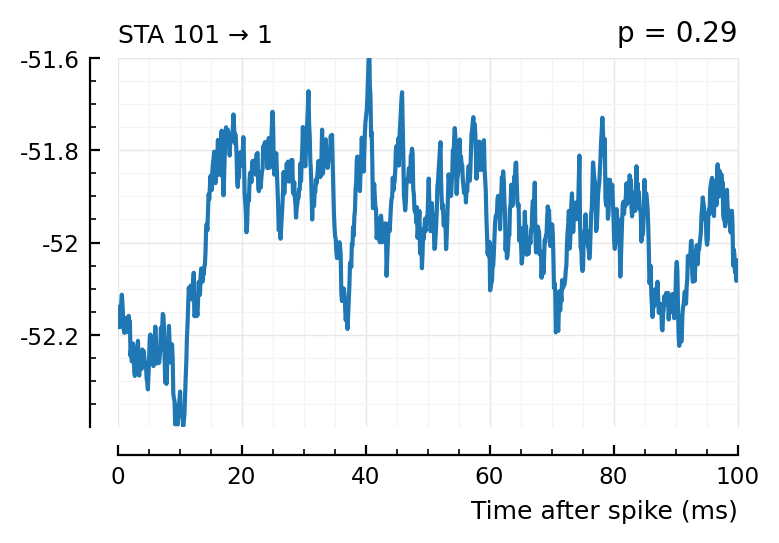

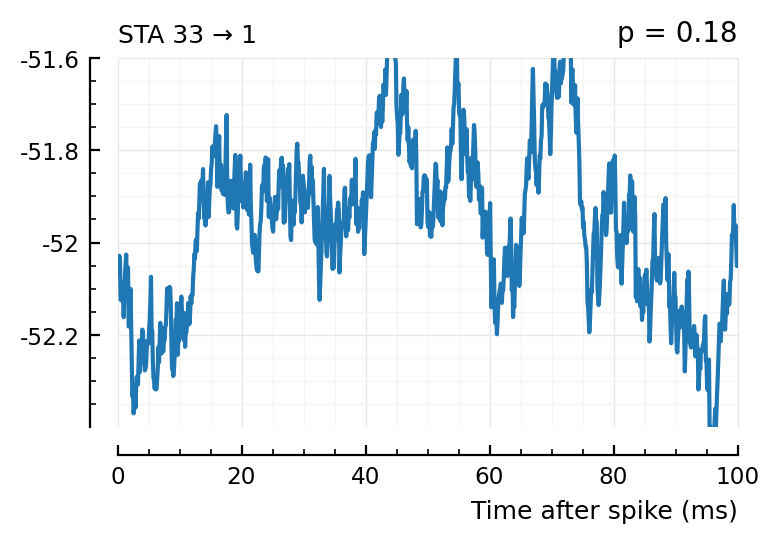

In [42]:
function plott(m)
    pval = first(tn[tn.input_neuron_ID .== m, :pval])
    plotSTA(m, 1, s,p; ylim = [-52.4, -51.6], hylabel="STA $m → 1", title="p = $pval")
end
plott(139);  # this one's detected, at p < 0.01
plott(565);  # all these ones not, p > 0.05
plott(136);
plott(194);
plott(352);
plott(800);
plott(101);
plott(33);

(The exc and inh inputs in the perf.tn table -- and so also the above plots -- are sorted by presyn firing rate).

Seems like we should be able to get that detection rate up no.
Especially the first three.

---

## Finding window length / time constant


We're gonna do something else entirely here, after supervision meeting sept 5. Finding time ct.

First naive idea: calc average STA of *all* other neurons in net to one.
Can we see the PSP?
hmm but we don't even know whether a neuron is inh or exc, and those might average out...

Can we somehow do an "absolute value" to negate that? (Same trick as in variance and MSE etc formulas, where it's done with square).

..so then we do need to ref. So let's do as before and subtract say the mean over the -- longish -- window.

We can reuse our calc_STA method: just wrap it and at the end subtract ref, and take abs;
then average the STAs.

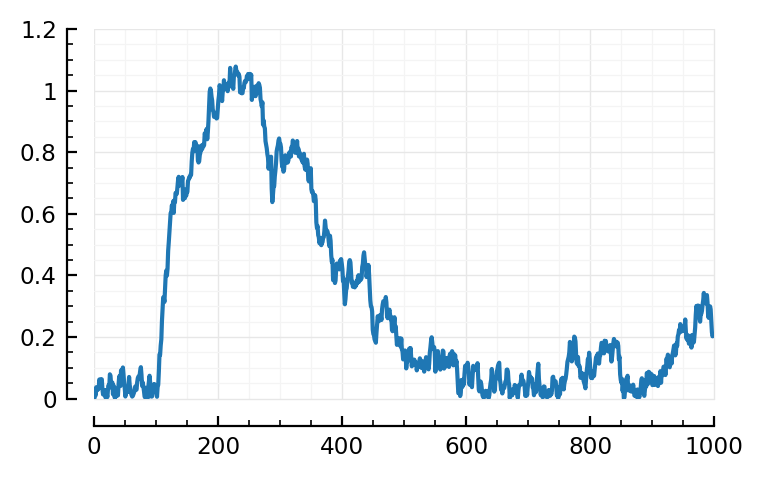

In [164]:
function rectify_centred_STA(from,to,s,p)
    STA = calc_STA(from,to,s,p)
    return abs.(STA .- STA[1])
end

Plot.plot(rectify_centred_STA(516,1,s,p) / mV);

In [216]:
function rect_STA_of_all_other(m, s=s, p=p, f=rectify_centred_STA)
    all_other = [n for n in s.neuron_IDs if n ≠ m]
    avg = f(all_other[1], m, s,p)
    @showprogress for n in all_other[2:end]
        avg .+= f(n, m, s,p)
    end
    avg ./= length(all_other)
    plotsig(avg / mV, p)
end;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


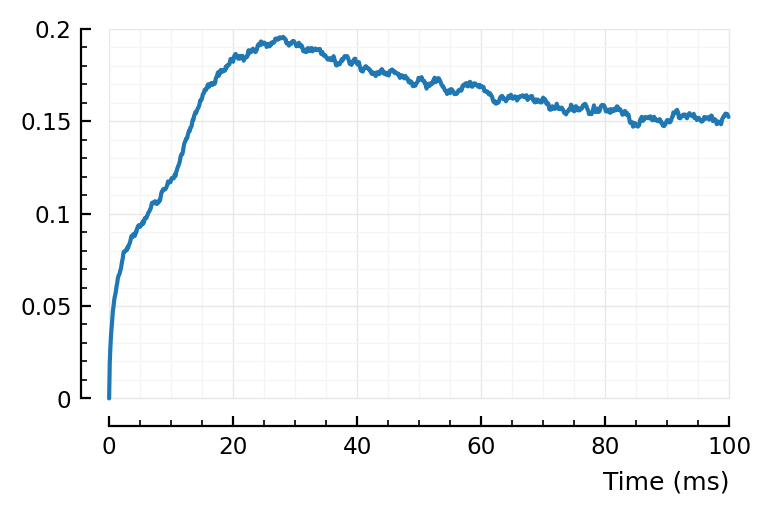

In [214]:
rect_STA_of_all_other(1);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


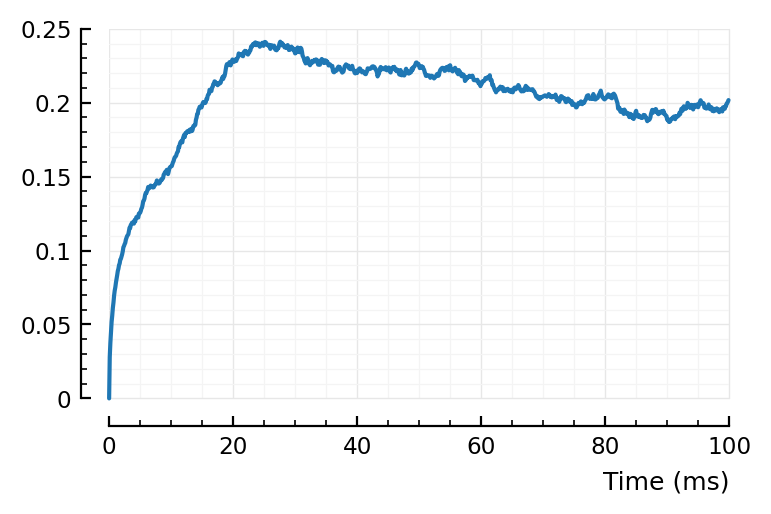

In [166]:
rect_STA_of_all_other(801);

Using `mean(STA)` as ref, nothing clear.
Using `STA[1]`: eh. There's bump around 25 ms? "Where the shape ('average rectified STA of all other neurons') starts decreasing again".

Would have to check with networks/neurons with other time constants and transmission delays.

--- 
Well I guess strategy to find window length could be: calculate all-to-all individual STAs (which you have to do anyway), with a guess for the window length on the medium-long side. Then look at one of the detected connections, and refine the window length based on the PSP shape you see.

We can have a different window duration per neuron like this too. The assumption is that we'll find at least one strong input connection per neuron at this medium-long window length.

---
We could run a simulation with other time constants, sure.
Let's try.

## Sim with other time cts

In [193]:
pp = get_params(
    duration = 10minutes,
    p_conn = 0.04,
    g_EE = 1,
    g_EI = 1,
    g_IE = 4,
    g_II = 4,
    ext_current = Normal(-0.5 * pA/√seconds, 5 * pA/√seconds),
    E_inh = -80 * mV,
    record_v = [1, 801],
    # ^ Same as before
    # but now:
    tx_delay = 20ms,
    C = 150pF,  # neuron capacitance, so ~ time constant
);

In [194]:
ss = cached(sim, [pp.sim]);

Running simulation: 100%|███████████████████████████████| Time: 0:09:59
Saving output at `C:\Users\tfiers\.phdcache\datamodel v2 (net)\sim\25219cc6c5b14b9c.jld2` … done (0.7 s)


In [195]:
ss = augment_simdata(ss, pp);

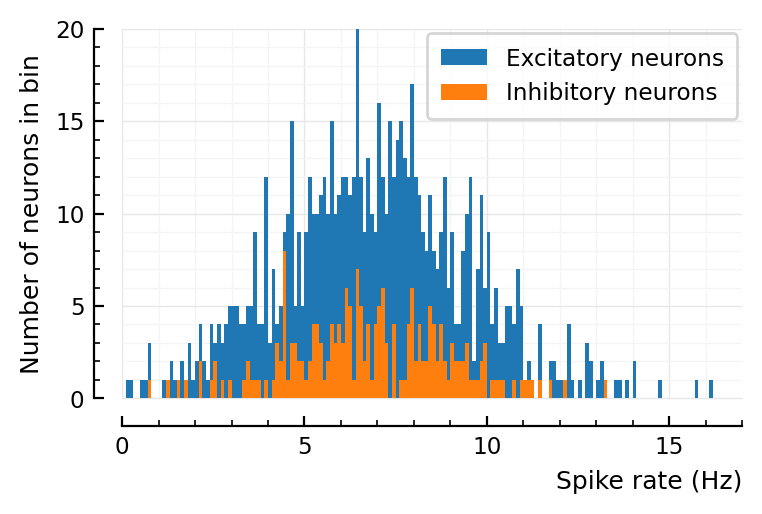

In [196]:
histplot_fr(ss.spike_rates);

Mean firing rate is about half as with prev params.

In [197]:
pp = (@set pp.conntest.STA_window_length = 200ms);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:13
Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


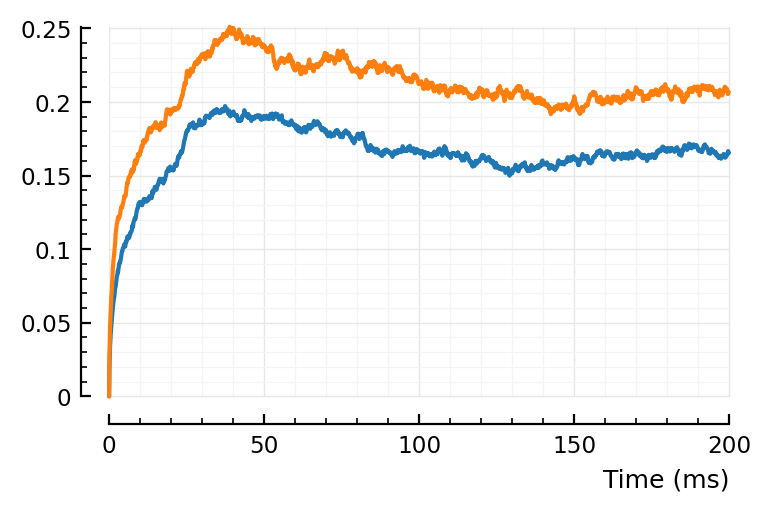

In [198]:
rect_STA_of_all_other(1, ss, pp);
rect_STA_of_all_other(801, ss, pp);

"Peak" seems later indeed :). Seems to go with timescales.

Above peak was at around 25 ms, here it's around 40 ms.

(Note that window here is 200 ms, and not the 100 ms of before).

In [199]:
perff = cached_conntest_eval(ss, 1, pp);

Testing connections: 100%|██████████████████████████████| Time: 0:01:06
Saving output at `C:\Users\tfiers\.phdcache\datamodel v2 (net)\evaluate_conntest_perf\cce4a52372f36a83.jld2` … done


In [200]:
perff.detection_rates

(TPR_exc = 0.462, TPR_inh = 0.9, FPR = 0.125)

In [206]:
perff_inh = cached_conntest_eval(ss, 801, pp);

Testing connections: 100%|██████████████████████████████| Time: 0:00:57
Saving output at `C:\Users\tfiers\.phdcache\datamodel v2 (net)\evaluate_conntest_perf\1840c60227d3caab.jld2` … done (0.1 s)


In [207]:
perff_inh.detection_rates

(TPR_exc = 0.476, TPR_inh = 0.6, FPR = 0.025)

In [203]:
ii = ss.input_info[1];
ii.exc_inputs[1]

139

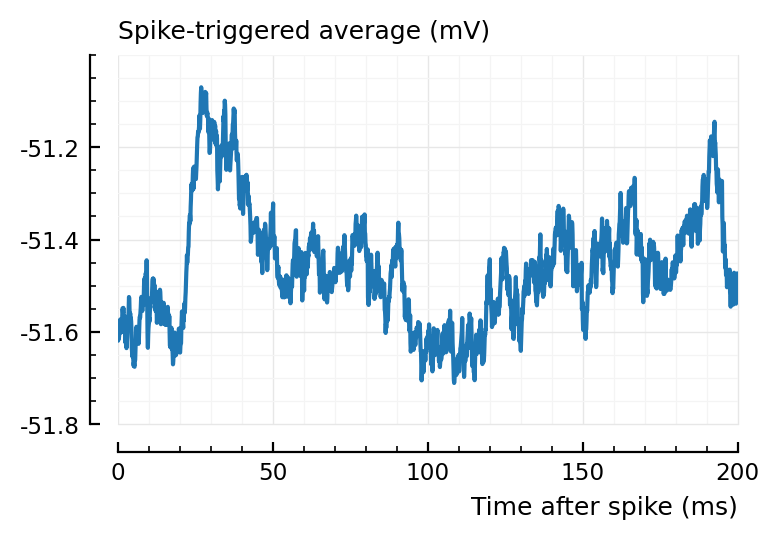

In [205]:
plotSTA(139, 1, ss,pp);

You can nicely see the 20 ms transmission delay.

Let's plot on 100 ms x axis, so easier to compare visually.

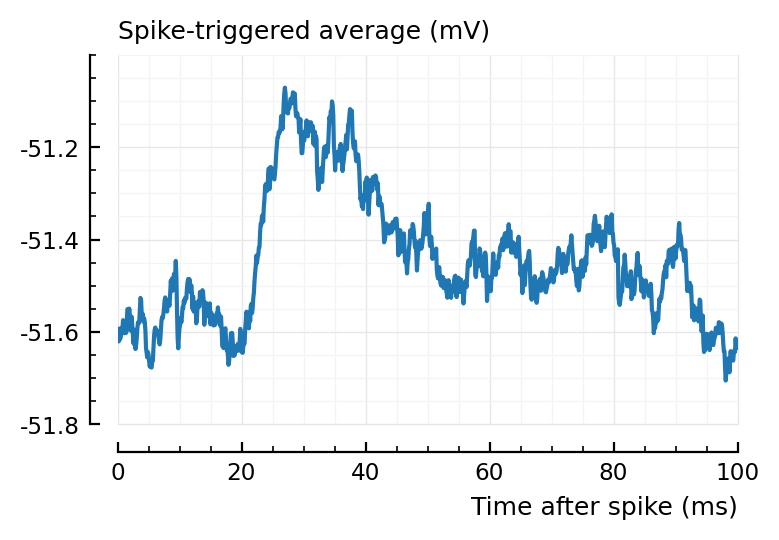

In [209]:
pq = (@set pp.conntest.STA_window_length = 100ms);
# to compare with previous sta plots:
plotSTA(139, 1, ss, pq);

What about the average STA (only for one neuron though here, instead of 40).

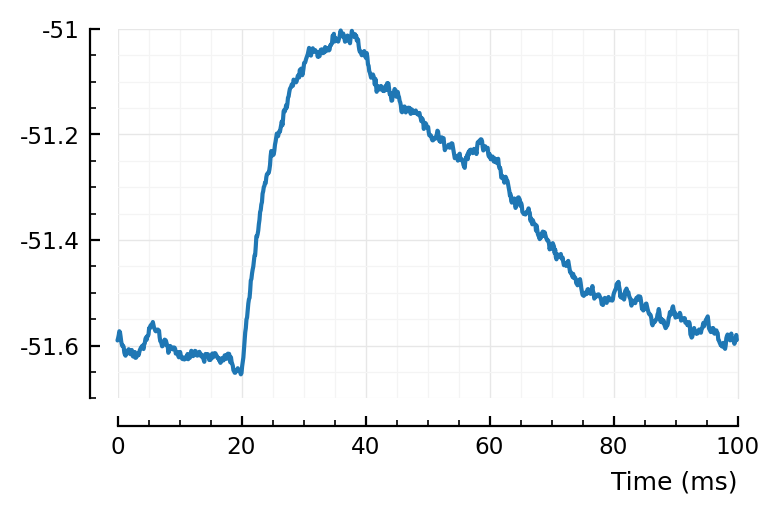

In [213]:
avg = mean([calc_STA(n, 1, ss, pq) for n in ii.exc_inputs]);
plotsig(avg / mV, pq);

Ah, this makes it clear: changing the capacitance `C` of course only affects the decay of the voltage.
We oughta change the synaptic (current integration) time constant, `synapses.τ`.

For prev sim, rise to top of PSP/STA was (starting after the 10 ms tx delay): ~12 ms.
Here (after 20 ms tx delay): ~16 ms. Ok so a bit longer sure.

---
So alright, seems like we can find this time constant from that `rect_STA_of_all_other` shape.

What does plain averaging STAs of all others look like again?

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


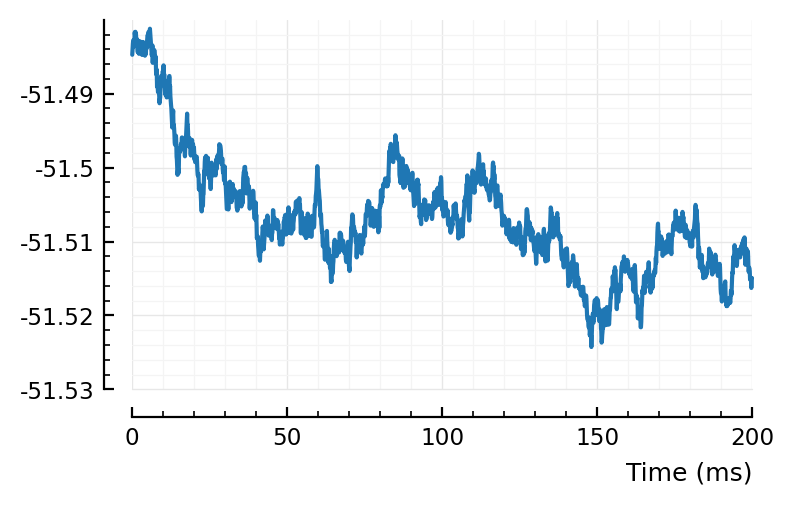

In [220]:
rect_STA_of_all_other(1, ss, pp, calc_STA);

(Function name is outdated, should be just "apply given function f to all other neurons, and average result". Where f is by default the STA-center-rectify func; but here is just plain STA).

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


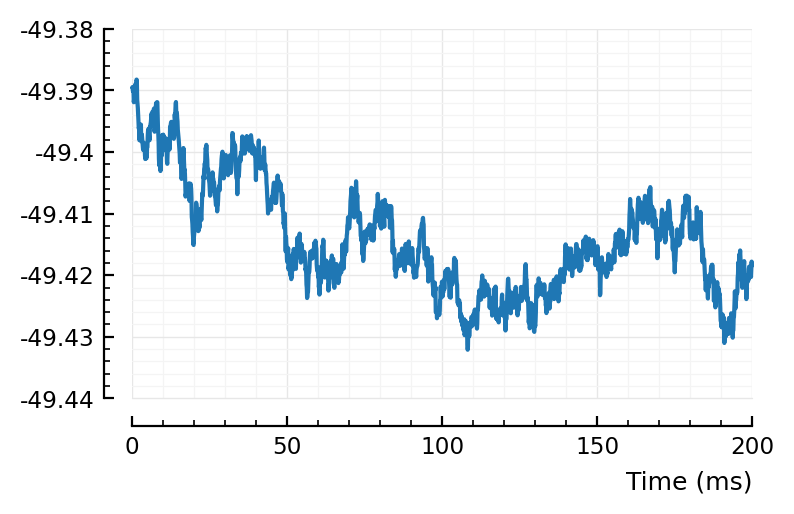

In [221]:
rect_STA_of_all_other(801, ss, pp, calc_STA);

(Ok, just averaging all STAs seems not helpful).

To properly test all this, I'd need a sim with different time constant and transmission delays per neuron/connection.

---

Back to "why not detected"

## Shuffled STAs

Let's for example look at..

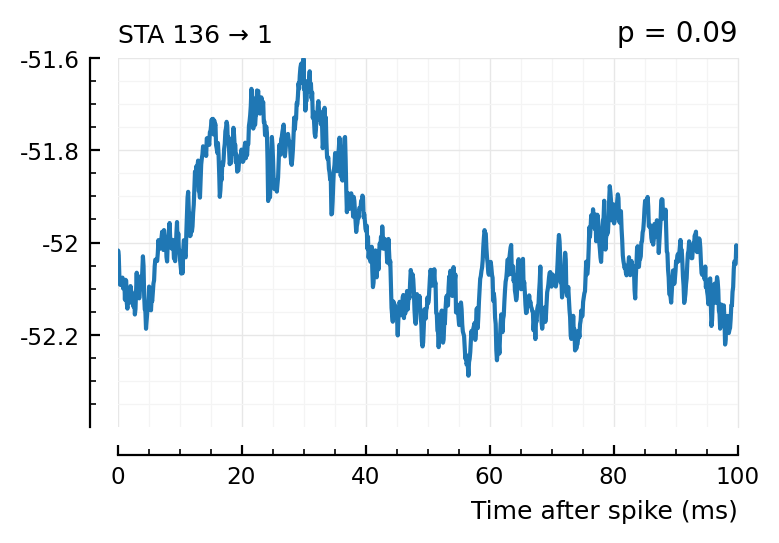

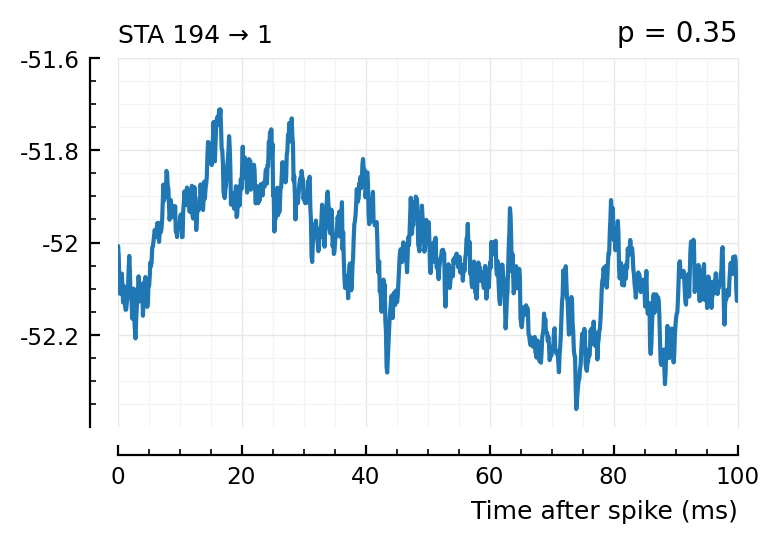

In [223]:
plott(136);
plott(194);

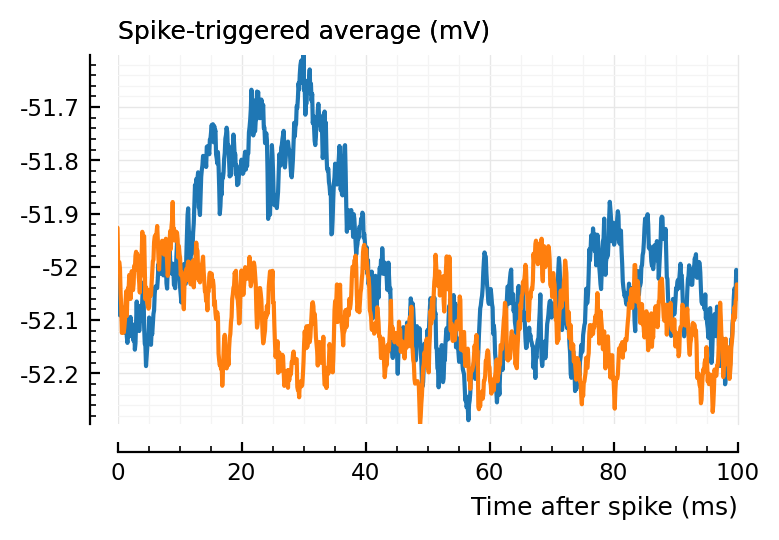

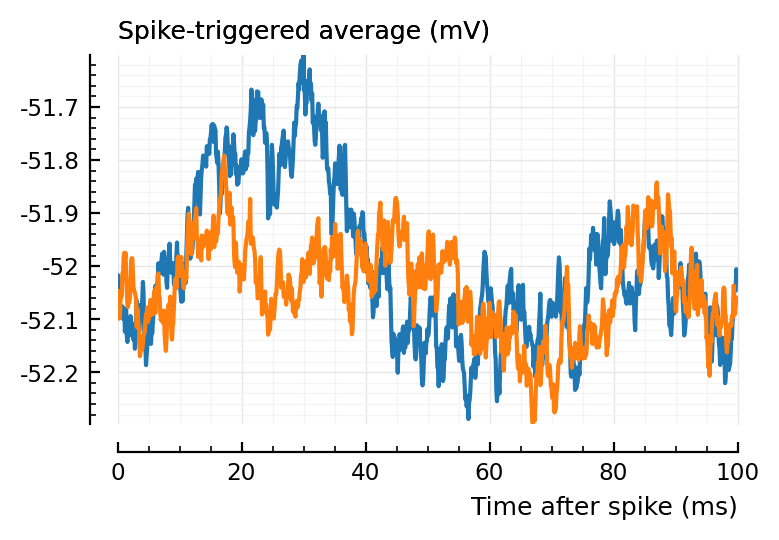

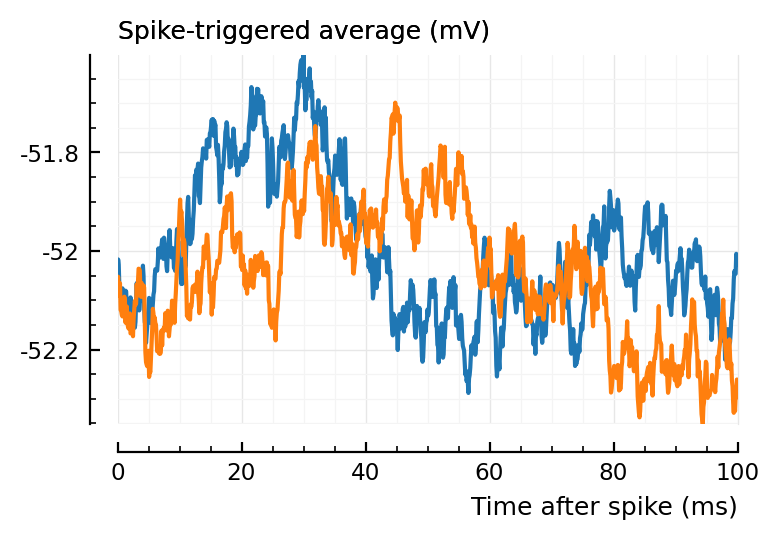

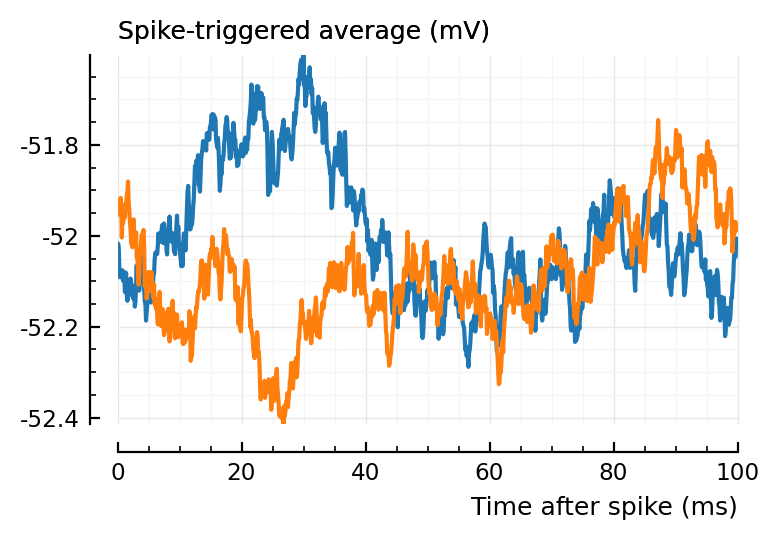

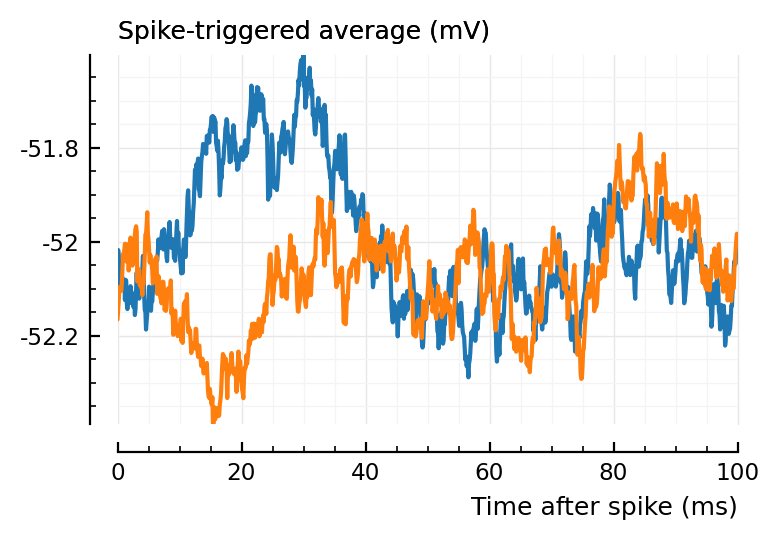

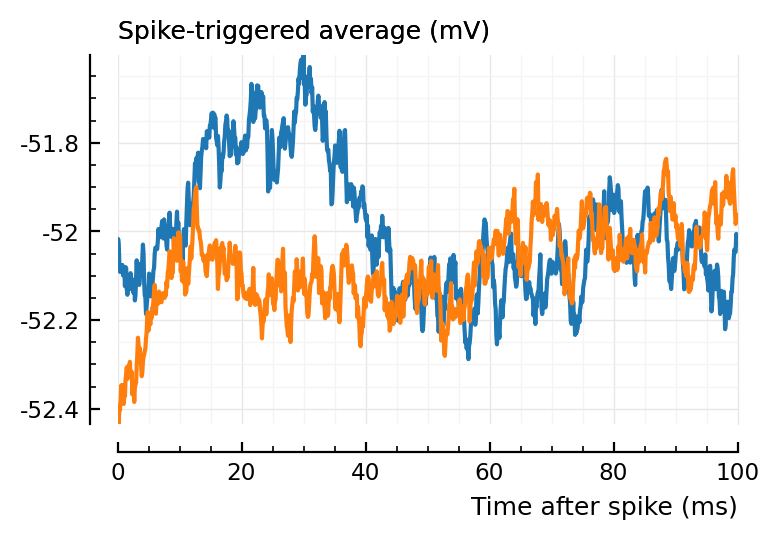

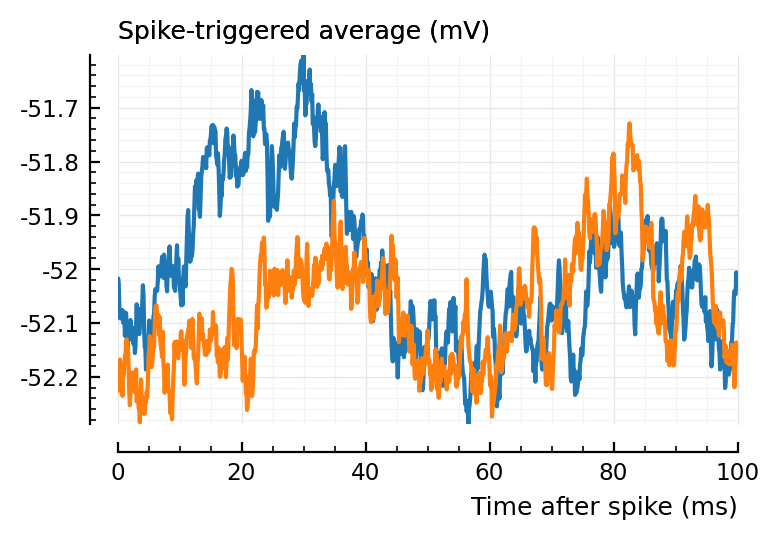

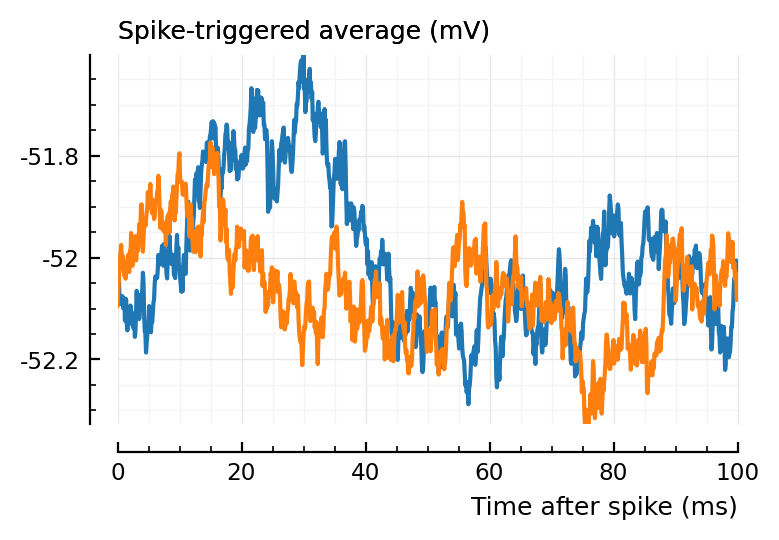

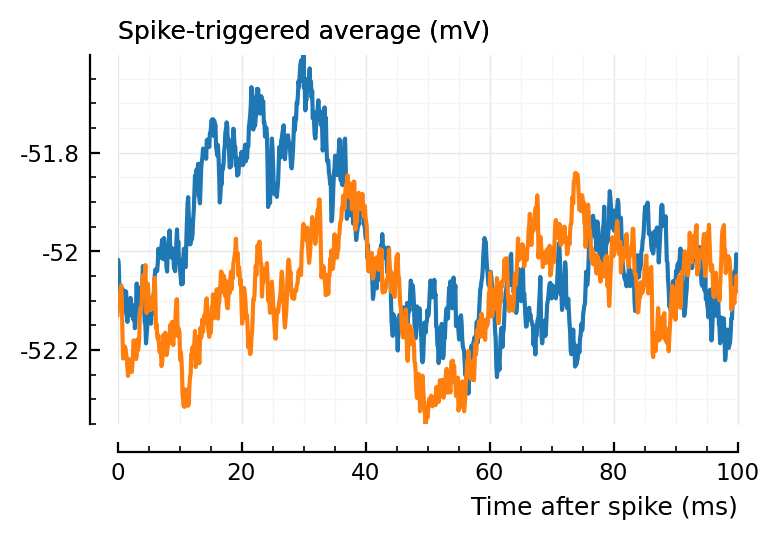

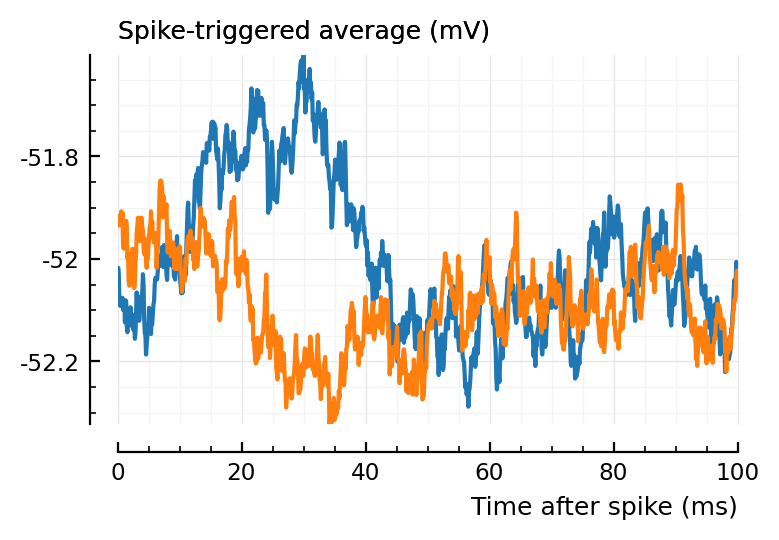

In [391]:
spikes = s.spike_times[136]
v = s.signals[1].v
#     resetrng!(i)
for i in 1:10
    shufspikes = shuffle_ISIs(spikes)
    ax = plotSTA(v, spikes, p)
    plotSTA(v, shufspikes, p; ax)
end

(Blue is the same 194 STA, orange are the STA for four shuffles of its ISIs).

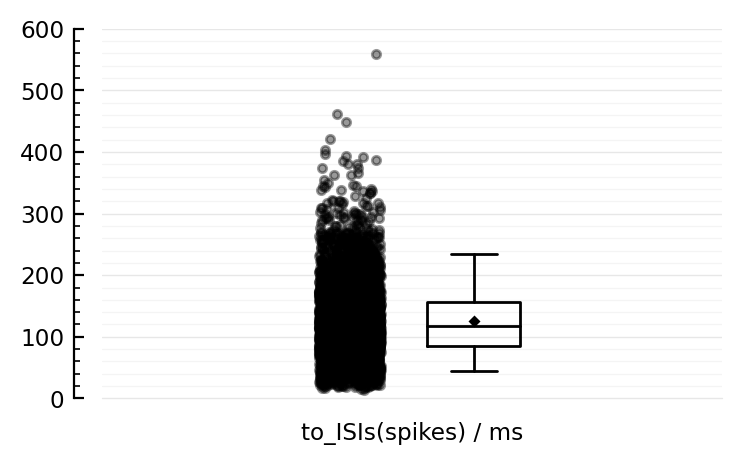

In [383]:
macro ydistplot(expr)
    :( ydistplot($(string(expr)) => $expr) )
end

@ydistplot to_ISIs(spikes) / ms;

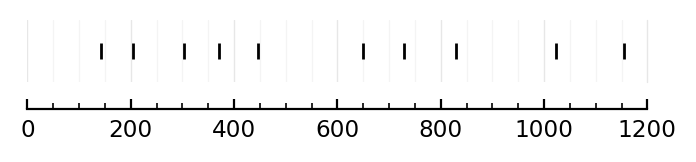

In [382]:
x = shuffle_ISIs(spikes)[1:10]
plt.subplots(figsize=(4,.4))
Plot.plot(x / ms, ones(length(x)), "k|", ytype=:off);

## Model PSP

In [132]:
t = 0:100
τ1 = 10
τ2 = 6
I = exp.(-t/τ1)
# Voltage (electric pot) U's impulse response has same form:
h_U = exp.(-t/τ2)
# U = convolve(I, h_U);

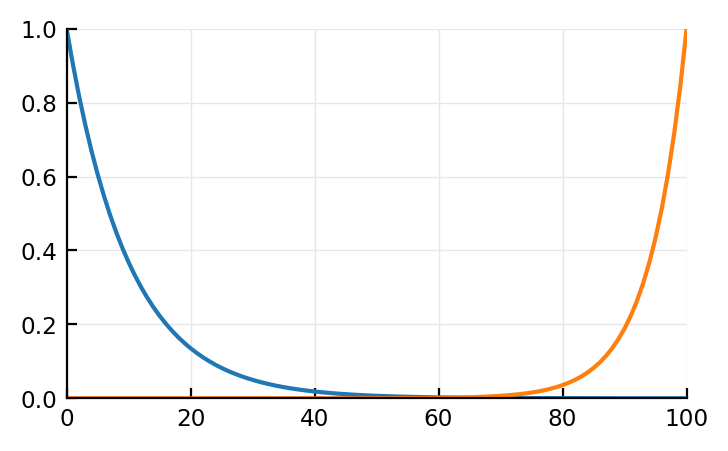

In [133]:
plot(t, I)
plot(t, h_U[end:-1:1]);

Trying mechanistically

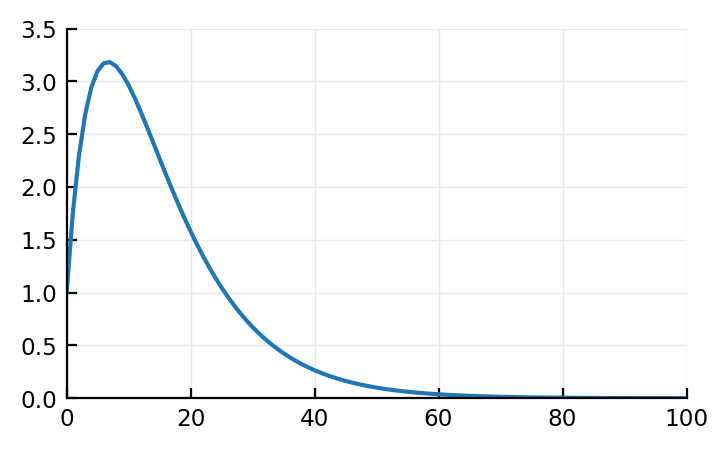

In [134]:
out = zeros(length(t))
x = I
y = h_U
out[1] = x[1]y[1]
out[2] = x[1]y[2] + x[2]y[1]
out[3] = x[1]y[3] + x[2]y[2] + x[3]y[1]
# etc

out = zeros(length(t))
for i = 1:length(x)
    for j = 1:i
        out[i] += x[j] * y[i-j+1]
    end
end

plot(t, out);

Analytically (thanks [sympy gamma](https://www.sympygamma.com/input/?i=integrate%28exp%28-t%2Fa%29*exp%28%28t-tau%29%2Fb%29%2C+%28t%2C+0%2C+tau%29%29) (takes a while to load). [wolfram alpha](https://www.wolframalpha.com/input?i=integrate+e%5E%28-t%2Fa%29+e%5E%28%28t-%CF%84%29%2Fb%29+dt+from+0+to+%CF%84) gives only one branch btw) (note that in these links, `a`=`τ1`, and `t`↔`τ`):

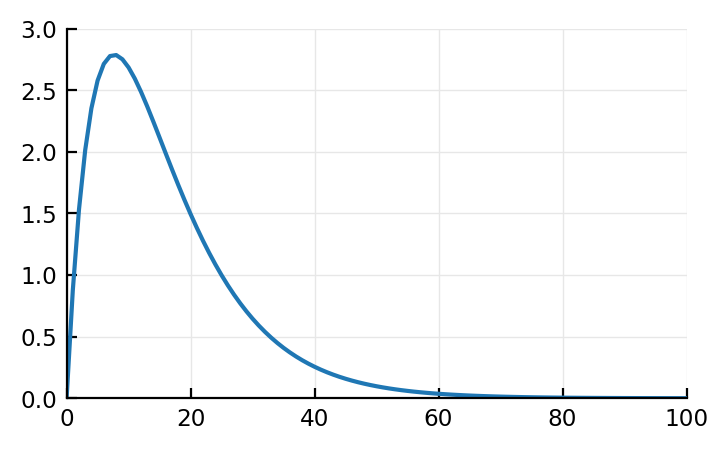

In [135]:
if τ1 == τ2
    U = @. t * exp(-t/τ1)
else
    U = @. τ1*τ2/(τ1-τ2) * (exp(-t/τ1) - exp(-t/τ2))
end

plot(U);

But is this actually what happens (conv of these two funcs)?  
It's in any case not what our STAs are (they have dimple).

Let's sim the diffeqs.

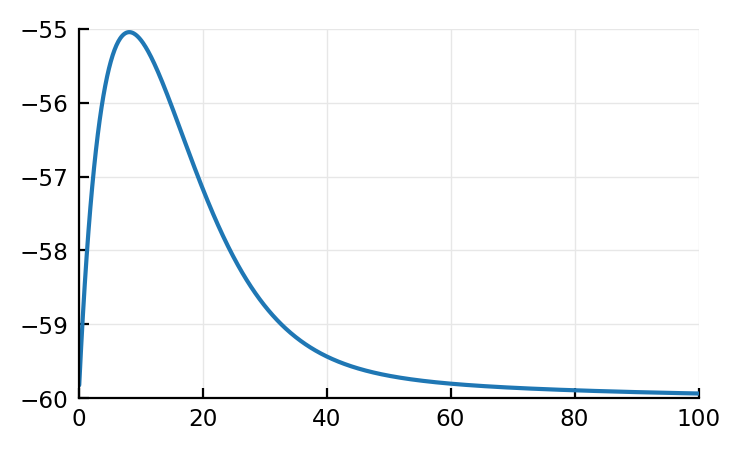

In [131]:
# cortical RS, same params as ever
Δt       =    0.1  * ms
g        =    3    * nS           # ..at t=0: Pulse
E_exc    =    0    * mV
τ        =    7    * ms
C        =  100    * pF
k        =    0.7  * (nS/mV)
v_rest   = - 60    * mV
v_thr    = - 40    * mV
a        =    0.03 / ms
b        = -  2    * nS
v        =    v_rest              # (..at t=0)
u        =    0    * pA           # (..at t=0)

N = 1000
vrec = zeros(N)
t = Δt * (1:N)

for i in 1:N
    g += Δt *  (-g / τ)
    v += Δt *  (k *  (v - v_rest) * (v - v_thr) - u - g*(v-E_exc)) / C
    u += Δt *  a * (b * (v - v_rest) - u)
    vrec[i] = v
end
v = vrec

plot(t / ms, v / mV);

Aha! So our model (convolution of two exponential decays) does seem quite right!
(It's cause it's all linear, when subthreshold (no matter what model: HH, Izh, LIF)).

Whence the dimple then...

Is it a postsynaptic spike effect? Like: "the EPSP increases change of spiking -- and after spike there's short rebound period" (and vice versa for IPSP: 'rebound' with _higher_ chance of spiking).

In that very early notebook where we deleted the Vm signal around postsynaptic spikes (60 ms before spike, 20 ms after), we still saw a (though slight) dimple in the STA: https://tfiers.github.io/phd/nb/2020-10-23__Delete_around_spike.html#plot-stas-of-all-spike-trains

..Though, revisiting it now, after 20 ms after the postsynaptic spike, the 'dimpling' may still be in effect. And those parts of the windows were not excised.

Might wanna try a simple LIF simulation: there is no rebound there.
Dimple should then disappear from STA and it should look more like these.

(See btw [here](https://tfiers.github.io/phd/nb/2020-09-18__Clip_spikes_before_STA.html#spike-triggered-windows) for some example windows).

---
Anyway, finding a (relatively simple, with not too many parameters) formula for the STA is interesting, but first, should see if this actually helps detection.
(Idea was to fit this function to an STA).